# 🧠 Projeto: Classificação de Tumores Cerebrais com InceptionV3

## 🧩 Inception (GoogLeNet)

Também conhecido como GoogleNet.

- Os módulos Inception funcionam convoluções de diferentes tamanhos que são aplicadas para criar um mapa de características diversificado.

- Os módulos Inception também incluem blocos de convolução 1x1, cuja função é reduzir a dimensionalidade. Ao realizar a convolução 1x1, o bloco Inception preserva as dimensões espaciais, mas reduz a profundidade, evitando que as dimensões gerais da rede cresçam exponencialmente.

- Além da camada de saída principal, esta rede também possui duas saídas auxiliares de classificação, que são usadas para injetar gradientes em camadas mais baixas .

<br><br>

The inception module is shown in the following figure:  

![](https://hackathonprojects.files.wordpress.com/2016/09/inception_implement.png?w=649&h=337)


<br>

## 📌 Contexto

Este projeto aplica uma rede neural convolucional baseada em InceptionV3 para detectar e classificar tumores cerebrais
em imagens de ressonância magnética (MRI). A identificação precoce de tumores é crucial para o diagnóstico e tratamento efetivo.


## 📦 Importando bibliotecas

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam


## 📁 Diretórios dos dados

In [3]:
train_dir = "/home/manoel/Documents/Deep_learning/Projeto Inception/tumor/Training"  
test_dir = "/home/manoel/Documents/Deep_learning/Projeto Inception/tumor/Testing"


## ⚙️ Parâmetros

In [4]:
img_size = (299, 299)
batch_size = 32 # define quantos exemplos o modelo vê de cada vez durante o treinamento.

## ✏️ Estudo da análise de dados

/tmp/ipykernel_3850/3607032985.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0], palette="Blues_d")
/tmp/ipykernel_3850/3607032985.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1], palette="Greens_d")


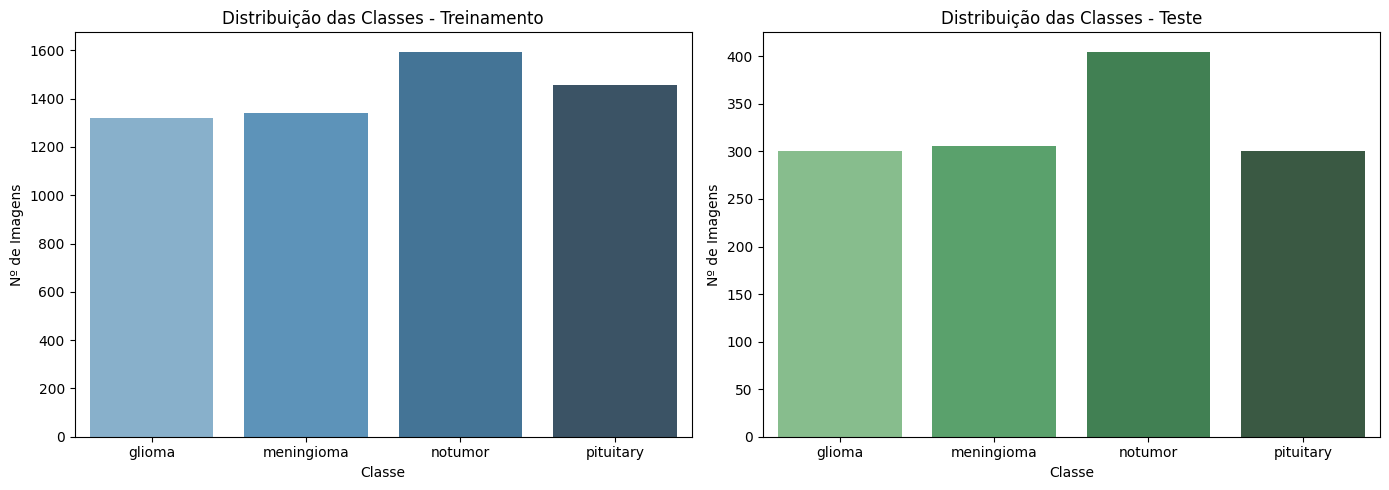

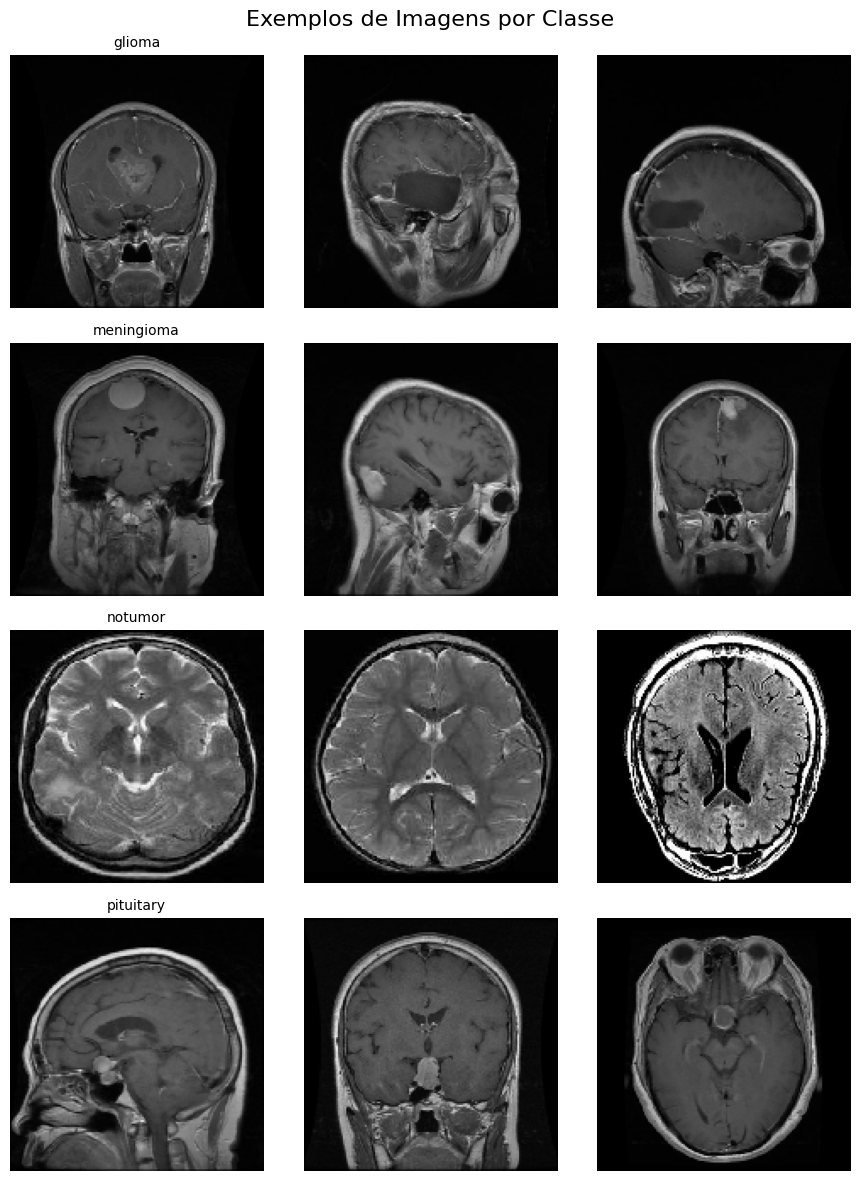

In [15]:
# Contar número de imagens por classe
def count_images(path):
    classes = os.listdir(path)
    counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in classes if os.path.isdir(os.path.join(path, cls))}
    return counts

train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Visualizar a distribuição das classes
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax[0], palette="Blues_d")
ax[0].set_title("Distribuição das Classes - Treinamento")
ax[0].set_xlabel("Classe")
ax[0].set_ylabel("Nº de Imagens")

sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax[1], palette="Greens_d")
ax[1].set_title("Distribuição das Classes - Teste")
ax[1].set_xlabel("Classe")
ax[1].set_ylabel("Nº de Imagens")

plt.tight_layout()
plt.show()

# Visualizar amostras
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array

def show_sample_images(path, n_samples=3):
    classes = os.listdir(path)
    fig, axes = plt.subplots(len(classes), n_samples, figsize=(n_samples * 3, len(classes) * 3))
    for i, cls in enumerate(classes):
        images = os.listdir(os.path.join(path, cls))[:n_samples]
        for j, img_name in enumerate(images):
            img = load_img(os.path.join(path, cls, img_name), target_size=(150, 150))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(cls, fontsize=10)
    plt.suptitle("Exemplos de Imagens por Classe", fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(train_dir)

## 🧼 Pré-processamento de imagens

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # Geração de imagem de treino com normalização
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input # Geração de imagem de teste com normalização
)

train_gen = train_datagen.flow_from_directory(   # Leitura dos dados de treinos gerados
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical' 
)

test_gen = test_datagen.flow_from_directory(    # Leitura dos dados de testes gerados
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## 🧠 Modelo com InceptionV3


In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299, 299, 3)))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output # pega a saída da última camada convulacional
x = GlobalAveragePooling2D()(x) # transforma a camada de saída em um vetor 1D
x = Dense(128, activation='relu')(x) # cria uma camanda densa de 128 neurônios com função de ativação ReLu (não-linearidade)
preds = Dense(train_gen.num_classes, activation='softmax')(x)  # cria uma camada de saída do modelo
model = Model(inputs=base_model.input, outputs=preds) # cria o model final completo

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy']) #compila

87910968/87910968 [==============================] - 32s 0us/step


## 🚀 Treinamento do modelo


In [7]:
history = model.fit(train_gen, validation_data=test_gen, epochs=10) # treina o modelo por número específico de épocas.


Epoch 1/10


2025-04-10 12:24:26.443891: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34329984 exceeds 10% of free system memory.
2025-04-10 12:24:26.477698: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 90935296 exceeds 10% of free system memory.
2025-04-10 12:24:27.107896: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34329984 exceeds 10% of free system memory.
2025-04-10 12:24:27.267921: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 88510464 exceeds 10% of free system memory.
2025-04-10 12:24:27.430261: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 177020928 exceeds 10% of free system memory.


179/179 [==============================] - 707s 4s/step - loss: 0.4738 - accuracy: 0.8186 - val_loss: 0.3923 - val_accuracy: 0.8505
Epoch 2/10
179/179 [==============================] - 789s 4s/step - loss: 0.2806 - accuracy: 0.8990 - val_loss: 0.3147 - val_accuracy: 0.8833
Epoch 3/10
179/179 [==============================] - 673s 4s/step - loss: 0.2257 - accuracy: 0.9170 - val_loss: 0.3023 - val_accuracy: 0.8780
Epoch 4/10
179/179 [==============================] - 877s 5s/step - loss: 0.1948 - accuracy: 0.9326 - val_loss: 0.4215 - val_accuracy: 0.8436
Epoch 5/10
179/179 [==============================] - 700s 4s/step - loss: 0.1744 - accuracy: 0.9401 - val_loss: 0.2051 - val_accuracy: 0.9161
Epoch 6/10
179/179 [==============================] - 606s 3s/step - loss: 0.1404 - accuracy: 0.9498 - val_loss: 0.2625 - val_accuracy: 0.8902
Epoch 7/10
179/179 [==============================] - 606s 3s/step - loss: 0.1306 - accuracy: 0.9555 - val_loss: 0.2067 - val_accuracy: 0.9138
Epoch 8/10

## 📈 Gráficos de desempenho


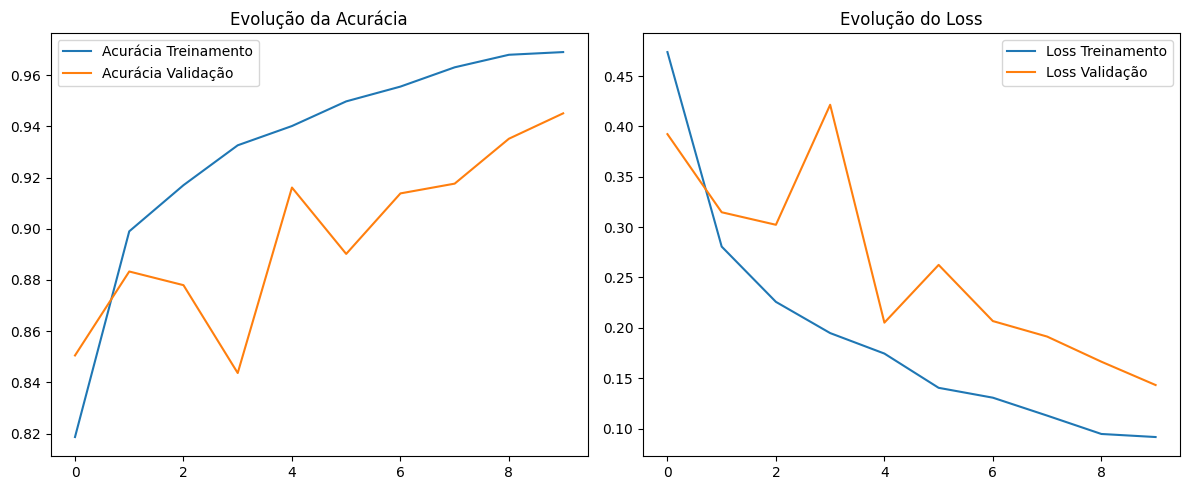

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.title('Evolução da Acurácia')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Treinamento') # taxa de erro do modelo
plt.plot(history.history['val_loss'], label='Loss Validação')
plt.title('Evolução do Loss')
plt.legend()
plt.tight_layout()
plt.show()


## 🧾 Avaliação final

41/41 [==============================] - 150s 3s/step

Relatório de Classificação:
              precision    recall  f1-score   support

      glioma       0.96      0.86      0.91       300
  meningioma       0.84      0.95      0.89       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.98      0.96      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



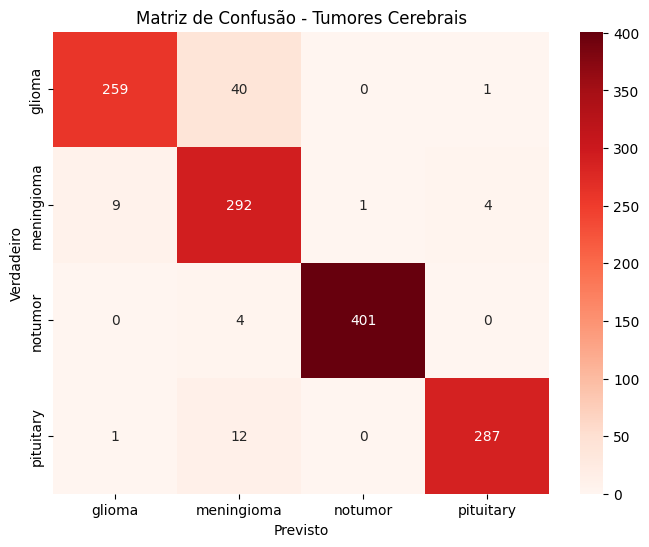

In [9]:
preds = model.predict(test_gen) # Usa o modelo treinado para prever as classes das imagens do conjunto de teste (test_gen).
y_pred = np.argmax(preds, axis=1) # seleciona o índice da maior probabilidade em cada linha
y_true = test_gen.classes # Recupera os rótulos verdadeiros das imagens no conjunto de teste.
labels = list(test_gen.class_indices.keys()) # Obtém os nomes das classes (como 'glioma', 'meningioma', 'pituitary', etc.).

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred) # Compara os rótulos verdadeiros com os previstos
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title("Matriz de Confusão - Tumores Cerebrais")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

## ✅ Conclusão

#### ✔️ Acurácia de Treinamento e Validação
- A **acurácia de treinamento** atingiu valores muito altos (~97%), indicando que o modelo aprendeu bem os dados.
- A **acurácia de validação** também foi alta (~93–94%), o que mostra **boa capacidade de generalização**, mesmo com pequenas oscilações.

#### 📉 Comportamento do Loss
- O **loss de treinamento** caiu de forma estável, como esperado.
- O **loss de validação**, embora oscilante, também seguiu uma tendência de queda — indicando **aprendizado sólido**, mas com sinais leves de **overfitting** (provavelmente pela complexidade do modelo).

### 🔍 Matriz de Confusão
- A **maioria das classes foi bem reconhecida**, com destaque para a classe **“Sem Tumor”**, que teve desempenho quase perfeito.
- As maiores confusões ocorreram entre **glioma, meningioma e pituitary**, o que é natural, pois são tumores com características visuais semelhantes em imagens de RM.
- Isso sugere que o modelo está capturando bem os padrões, mas ainda pode ser melhorado em áreas específicas.

### 🧠 Forças do Modelo
- Excelente desempenho em imagens reais.
- Boa capacidade de generalização para o conjunto de teste.
- Arquitetura robusta (InceptionV3) já comprovada em desafios de visão computacional.

